# 0. Setups

In [51]:
import os
import time
import sys

import numpy as np
import pandas
from skimage import io, transform, exposure
import matplotlib.pyplot as plt
import tqdm
import albumentations as Alb
import tifffile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

# 1. Configuration

In [52]:
class CFG:
    """
    Configuration class for the blood vessel segmentation project.
    """

    # ============== Model Configuration =============
    MODEL_NAME = 'Unet'
    BACKBONE = 'se_resnext50_32x4d'
    IN_CHANNEL = 1  # Number of input channels (e.g., 1 for grayscale images)
    OUT_CHANNEL = 1 # Number of output channels

    # ============== Image Processing Settings =============
    INPUT_IMAGE_SIZE = (1024, 1024)  # Size of the input images (height x width)
    GAMMA = 1

    # =============
    # = Training and Validation Parameters =============
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    VALID_ID = 1  # ID for validation dataset or fold
    BATCH_SIZE = 1  # Batch size for model training
    THRESHOLD_PERCENTILE = 0.0014109  # Threshold for post-processing
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 50
    NUM_WORKERS = 0 # Number of threds
    TRAIN_TEST_SPLIT_RATIO = 0.2 # for test subset

    # ============== Model Paths =============
    # List of paths to trained model weights
    MODEL_PATHS = [
        "/path/to/model1.pt",
        "/path/to/model2.pt",
        # Add more model paths as needed
    ]
    
    # ============== Data Paths =============
    DATASET_NAME = "kidney_1_dense"
    DATASET_DIRECTORY = os.path.join("..", "data")
    TRAIN_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "train", DATASET_NAME)
    TEST_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "test", DATASET_NAME)

# 2. Load Dataset

### 2.1. Custom Dataset Class

In [53]:
class CustomDataset(Dataset):
    def __init__(self, image_path, mask_path=None, target_image_size=(512, 512), convert_size=True, gamma=1, image_format=".tif"):
        # File IO
        self.image_path = image_path
        self.image_format = image_format
        self.image_filenames = sorted([os.path.join(self.image_path, filename) for filename in os.listdir(self.image_path) if filename.endswith(self.image_format)])
        print(f"{len(self.image_filenames)} images are loaded.")

        # If masks (labels) are given
        self.mask_path = mask_path
        if self.mask_path:
            self.mask_filenames = sorted([os.path.join(self.mask_path, filename) for filename in os.listdir(self.mask_path) if filename.endswith(self.image_format)])
            if not len(self.mask_filenames) == len(self.image_filenames):
                raise(f"Number of images and labels are not matched: {len(self.image_filenames)} images and {len(self.mask_filenames)} labels.")
            print(f"{len(self.mask_filenames)} labels are loaded.")

        # Image processing
        self.target_image_size = target_image_size
        self.convert_size = convert_size
        self.gamma = gamma

        # Process and print the size of the first image if convert_size is True
        if self.convert_size and len(self.image_filenames) > 0:
            first_image = io.imread(self.image_filenames[0])
            resized_image = self.resize_and_pad(first_image, self.target_image_size)
            print(f"Original size: {first_image.shape}, Converted size: {resized_image.shape}")

    def __getitem__(self, index):
        # Load image
        image = io.imread(self.image_filenames[index])

        # Resize and pad the image if convert_size is True
        if self.convert_size:
            image = self.resize_and_pad(image, self.target_image_size, self.gamma)
        
        # Extract the filename
        image_filename = os.path.basename(self.image_filenames[index])

        # If masks (labels) are given
        if self.mask_path:
            mask = io.imread(self.mask_filenames[index])
            mask = self.resize_and_pad(mask, self.target_image_size, gamma=1) # mask containing 0s and 1s only.
            return image, mask, image_filename

        return image, image_filename

    def __len__(self):
        return len(self.image_filenames)

    def resize_and_pad(self, image, target_image_size, gamma=1):
        """Resize an image and add padding to keep aspect ratio."""
        # Calculate scale and padding
        h, w = image.shape[:2]
        scale = min(target_image_size[0] / h, target_image_size[1] / w)
        new_h, new_w = int(h * scale), int(w * scale)
        pad_h = (target_image_size[0] - new_h) // 2
        pad_w = (target_image_size[1] - new_w) // 2

        # Resize image with preserve_range set to True
        image_resized = transform.resize(
            image,
            (new_h, new_w),
            anti_aliasing=True,
            mode='constant',
            preserve_range=True,  # This will preserve the original image's intensity range
            order=1
        )

        # Apply gamma correction to adjust brightness
        if not gamma == 1:
            image_resized = exposure.adjust_gamma(image_resized, gamma)

        # Add a channel dimension to grayscale images if necessary
        if len(image.shape) == 2:  # Grayscale image
            image_resized = image_resized[..., np.newaxis]

        # Initialize padded image
        padded_image = np.zeros((target_image_size[0], target_image_size[1], image_resized.shape[2]), dtype=image_resized.dtype)

        # Insert the resized image into the padded image
        padded_image[pad_h:pad_h+new_h, pad_w:pad_w+new_w, :] = image_resized

        return padded_image

### 2.2. Display Function

In [54]:
def display_image(images, titles=None, max_cols=4):
    # Wrap single image in a list
    if not isinstance(images, list):
        images = [images]
        titles = [titles] if titles is not None else titles

    if titles is not None and not isinstance(titles, list):
        raise TypeError("Titles should be provided as a list or a single title for a single image.")

    if titles and len(images) != len(titles):
        raise ValueError("Every image should have a corresponding title.")

    num_images = len(images)
    cols = min(num_images, max_cols)
    rows = num_images // cols + (num_images % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    if rows == 1 or cols == 1:
        axes = np.array([axes])

    axes = axes.flatten()[:num_images]  # Limit to the number of images to avoid blank subplots

    for ax, img, title in zip(axes, images, titles or [None]*num_images):
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()
            if img.ndim == 3 and img.shape[0] in [1, 3, 4]:
                img = img.transpose(1, 2, 0)
            if img.ndim == 3 and img.shape[2] == 1:
                img = img.squeeze(2)

        ax.imshow(img, cmap='gray')
        if title:
            ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### 2.3. Load dataset and display sample image

In [55]:
image_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images")
mask_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "labels")
dataset = CustomDataset(image_path, mask_path, target_image_size=CFG.INPUT_IMAGE_SIZE, gamma=CFG.GAMMA)

2279 images are loaded.
2279 labels are loaded.
Original size: (1303, 912), Converted size: (1024, 1024, 1)


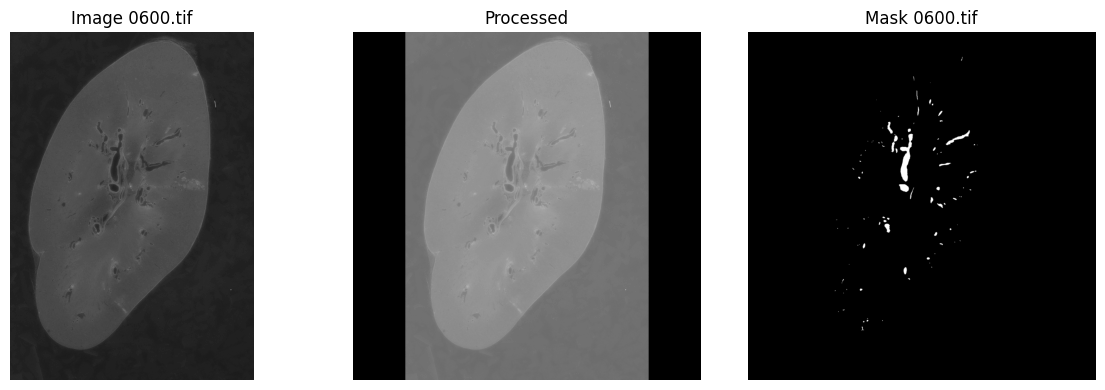

In [56]:
index = 600
original_image = io.imread(os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images", dataset[index][2]))
display_image([original_image, dataset[index][0], dataset[index][1]], [f"Image {dataset[index][2]}", "Processed", f"Mask {dataset[index][2]}"])

### 2.4. Train-Test-Split and DataLoader

In [57]:
# Calculate the sizes of train and test sets
total_size = len(dataset)
test_size = int(total_size * CFG.TRAIN_TEST_SPLIT_RATIO)
train_size = total_size - test_size

# Randomly split the dataset into train and test
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Now you can create DataLoaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=CFG.NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

# 3. Image Augmentation

In [58]:
def Augement_image(image, mask):

    image_dense = torch.from_numpy(image.astype(np.float32))
    mask_dense = torch.from_numpy(mask.astype(np.float32))

    if len(image_dense.shape) == 2:
        image_dense = image_dense.unsqueeze(0)

    image_np = image_dense.permute(1, 2, 0).numpy()
    mask_np = mask_dense.numpy()

    image_list = [None, None, None, None]
    mask_list = [None, None, None, None]
    
    transform_rotate_90 = Alb.Compose([
        Alb.Rotate(limit=90, p=0.5)
    ])

    # Original image
    image_list[0] = image_np
    mask_list[0] = mask_np

    # Original image with 90-degree rotation
    augmented_rotate_90 = transform_rotate_90(image=image_np, mask=mask_np)
    image_list[1], mask_list[1] = augmented_rotate_90['image'], augmented_rotate_90['mask']

    # Original image with 180-degree rotation
    augmented_rotate_180 = transform_rotate_90(image=image_list[1], mask=mask_list[1])   
    image_list[2], mask_list[2] = augmented_rotate_180['image'], augmented_rotate_180['mask']

    # Original image with 270-degree rotation
    augmented_rotate_270 = transform_rotate_90(image=image_list[2], mask=mask_list[2])
    image_list[3], mask_list[3] = augmented_rotate_270['image'], augmented_rotate_270['mask']

    # Making the mask dimentions 3
    for i in range(4):
        if mask_list[i].ndim == 2:
            mask_list[i] = mask_list[i][..., np.newaxis]

    augmented_data_zip = list(zip(*[image_list, mask_list]))

    return augmented_data_zip

In [59]:
data_set = 'kidney_2'

image_path = os.path.join('..', 'data', 'train', data_set, 'images')
label_path = os.path.join('..', 'data', 'train', data_set, 'labels')

image_files = sorted([os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(label_path, f) for f in os.listdir(label_path) if f.endswith('.tif')])

# Load an example image and label
first_image = tifffile.imread(image_files[981])
first_label = tifffile.imread(label_files[981])

# Augment the image and label
# augmented_image, augmented_mask = Augement_image(first_image, first_label)
augmented_zip = Augement_image(first_image, first_label)

# Show the augmented image
# display_image(augmented_image)
# display_image(augmented_mask)

# is_image_tensor = isinstance(augmented_image, np.ndarray)
# is_mask_tensor = isinstance(augmented_mask, np.ndarray)
# print(is_image_tensor, is_mask_tensor)
# print(augmented_zip)
# display_image(augmented_zip[-1][-1])

# RLE Encoding & Decoding

In [60]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    if rle == '':
        rle = '1 0'
    return rle

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Model

## 1.1 Convolution Block

In [61]:
""" Convolution Block """
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(out_channel)

        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channel, out_channel, kernal_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)


    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

## 1.2 Encoder Block

In [62]:
""" Encoder Block """
class EncoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.conv = ConvBlock(in_channel, out_channel)
        self.pool = nn.MaxPool2d(kernal_size=(2, 2))


    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

## 1.3 Decoder Block

In [63]:
""" Decoder Block """
class DecoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=(2, 2), stride=2, padding=0)
        self.conv = ConvBlock(in_channel, out_channel)


    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

## 1.4 Attention Block

In [64]:
class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, F_i):
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, F_i, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_i)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_i, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_i)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_i, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, X):
        g1 = self.W_gate(gate)
        x1 = self.W_x(X)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = X * psi
        return out


## 1.5 VGG

In [67]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(VGGBlock, self).__init__()

        layers = []
        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.vgg_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.vgg_block(x)

class VGGNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(VGGNet, self).__init__()

        self.encoder = nn.Sequential(
            VGGBlock(in_channels, 64, 2),
            VGGBlock(64, 128, 2),
            VGGBlock(128, 256, 3),
            VGGBlock(256, 512, 3),
            VGGBlock(512, 512, 3)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            VGGBlock(512, 256, 3),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            VGGBlock(256, 128, 2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            VGGBlock(128, 64, 2),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            VGGBlock(64, 32, 2)
        )

        self.attention_block = AttentionBlock(512, 256, 256)  # Assuming attention between encoder and decoder

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        encoder_outputs = []

        # Encoder
        for block in self.encoder:
            x = block(x)
            encoder_outputs.append(x)

        # Attention between encoder and decoder
        attention_output = self.attention_block(encoder_outputs[-1], encoder_outputs[-2])

        # Decoder
        x = self.decoder(attention_output)

        # Final convolution
        x = self.final_conv(x)

        return x

# Example usage:
in_channels = 3  # Assuming input images have 3 channels (e.g., RGB)
num_classes = 1  # Number of segmentation classes
model = VGGNet(in_channels, num_classes)

# Loss function

In [68]:
class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        focal_loss = -((1 - pt) ** self.gamma) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss
